In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, chi2, kstwobign, ks_2samp, cauchy, logistic

import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.special import eval_sh_legendre
from typing import List
from tqdm import tqdm
from typing import *
import plotly.express as px

# Utils

In [2]:
def phi_1(x):
    return np.sqrt(3)*(2*x - 1)

def phi_2(x):
    return np.sqrt(48) * (0.25 - abs(x - 0.5))

In [3]:
def t_statistic(m, n, phi, X, Y):
    N = m + n
    ranked = np.array(pd.DataFrame(np.hstack([X,Y])).rank()).flatten()
    ranked_X = ranked[:m]
    ranked_Y = ranked[m:]
    sum_1 = sum(phi((ranked_X - 0.5) / N))
    sum_2 = sum(phi((ranked_Y - 0.5) / N))
    return np.sqrt(m*n/N) * (1/m * sum_1 - 1/n * sum_2)

def cum_dst(sample, x):
    n = sample.shape[0]
    return sample[sample <= x].shape[0] / n

def ks_statistics(m, n, X, Y):
    N = m + n
    ordered_x = np.sort(X)
    ordered_y = np.sort(Y)
    sup = 0

    for i in range(ordered_x.shape[0]):
        x_i = ordered_x[i]

        if i == 0:
            x_j = -np.inf
        else:
            x_j = ordered_x[i -1]

        pot_sup = max(
            abs(cum_dst(X, x_i) - cum_dst(Y, x_j)),
            abs(cum_dst(X, x_i) - cum_dst(Y, x_i)),
        )

        sup = max(pot_sup, sup)

    for i in range(ordered_y.shape[0]):
        y_i = ordered_y[i]

        if i == 0:
            y_j = -np.inf
        else:
            y_j = ordered_y[i -1]

        pot_sup = max(
            abs(cum_dst(Y, y_j) - cum_dst(Y, y_i)),
            abs(cum_dst(Y, y_i) - cum_dst(Y, y_i)),
        )

        sup = max(pot_sup, sup)

    res = np.sqrt(m*n / N) * sup
    return res


# EX 1

In [4]:
n = 20
m = 20
W_results = []
AB_results = []
L_results = []
KS_results = []
for _ in tqdm(range(10000)):
    X = np.random.normal(size=m)
    Y = np.random.normal(size=n)
    w, ab = t_statistic(m, n, phi_1, X, Y), t_statistic(m, n, phi_2, X, Y)
    ks = ks_statistics(m, n, X, Y) 
    #ks = np.sqrt(n*m / (n+m)) * ks_2samp(X,Y).statistic #

    W_results.append(w**2)
    AB_results.append(ab**2)
    L_results.append(w**2 + ab**2)
    KS_results.append(ks)

theoretical = chi2.ppf(0.95, 1)
AB_critical = sorted(AB_results)[9499]
W_critical = sorted(W_results)[9499]
L_critical = sorted(L_results)[9499]
KS_critical = sorted(KS_results)[9499]

print(f"Standard normal 0.95-quantile: {theoretical}")
print(f"Wilcoxon test 0.95-quantile: {W_critical}")
print(f"Ansari-Bradley test 0.95-quantile: {AB_critical}\n")

theoretical = chi2.ppf(0.95, 2)
print(f"Chi squared with 2 df 0.95-quantile: {theoretical}")
print(f"Lapage test 0.95-quantile: {L_critical}\n")

theoretical = kstwobign.ppf(0.95)
print(f"KS 0.95-quantile: {theoretical}")
print(f"KS test 0.95-quantile: {KS_critical}")

100%|██████████| 10000/10000 [00:06<00:00, 1662.33it/s]


Standard normal 0.95-quantile: 3.841458820694124
Wilcoxon test 0.95-quantile: 3.888000000000001
Ansari-Bradley test 0.95-quantile: 3.887999999999999

Chi squared with 2 df 0.95-quantile: 5.991464547107979
Lapage test 0.95-quantile: 5.89275

KS 0.95-quantile: 1.3580986393225505
KS test 0.95-quantile: 1.264911064067352


# EX 2

In [23]:
def make_experiment(func, params, n, m):
    cr_w = chi2.ppf(0.95, 1)
    cr_ab = chi2.ppf(0.95, 1)
    cr_l = chi2.ppf(0.95, 2)
    cr_ks = kstwobign.ppf(0.95)
    
    test_statistics = {
        'scale': [],
        'shift' : [],
        'W' : [],
        'AB' : [],
        'L' : [],
        'KS' : [],
    }
    powers = []
    for x_params,y_params in params:
        w,ab,l,ks = [],[],[],[]
        
        for i in tqdm(range(10000)):
            X = func(size=m, loc = x_params[0], scale = x_params[1])
            Y = func(size=m, loc = y_params[0], scale = y_params[1])
            w_s, ab_s = t_statistic(m, n, phi_1, X, Y), t_statistic(m, n, phi_2, X, Y)

            w.append(w_s**2)
            ab.append(ab_s**2)
            l.append(w_s**2 + ab_s**2)
            ks.append(ks_statistics(m, n, X, Y))

        powers.append([y_params[0], y_params[1], 'W', sum(w > cr_w) / len(w)])
        powers.append([y_params[0], y_params[1], 'AB', sum(ab > cr_ab) / len(ab)])
        powers.append([y_params[0], y_params[1], 'L', sum(l > cr_l) / len(l)])
        powers.append([y_params[0], y_params[1], 'KS', sum(ks > cr_ks) / len(ks)])

        test_statistics['shift'].append(y_params[0])
        test_statistics['scale'].append(y_params[1])
        test_statistics['W'].append(ks[0])
        test_statistics['AB'].append(ab[0])
        test_statistics['L'].append(l[0])
        test_statistics['KS'].append(ks[0])

    return pd.DataFrame(test_statistics), pd.DataFrame(powers, columns=['shift', 'scale', 'test', 'power'])
        
        

## a)

In [24]:
t_stat, powers = make_experiment(
    func=norm.rvs,
    params=[
        ([0, 1], [0.2, 1.0]), 
        ([0, 1], [0.4, 1.0]), 
        ([0, 1], [0.6, 1.0]),
        ([0, 1], [0.8, 1.0]), 
        ([0, 1], [1.0, 1.0]), 
        ([0, 1], [1.2, 1.0]),
        ([0, 1], [1.4, 1.0])
    ],
    n=20,
    m=20
    )

100%|██████████| 10000/10000 [00:05<00:00, 1850.74it/s]


In [25]:
t_stat

,scale,shift,W,AB,L,KS
0,1.0,0.2,0.632456,1.587,2.30775,0.632456
1,1.0,0.4,1.264911,0.003,2.03100,1.264911
2,1.0,0.6,1.739253,0.027,8.93775,1.739253
3,1.0,0.8,1.423025,4.332,8.32875,1.423025
4,1.0,1.0,1.897367,0.675,9.42300,1.897367
5,1.0,1.2,2.213594,0.003,15.99000,2.213594
6,1.0,1.4,2.055480,1.323,12.48600,2.055480


In [26]:
powers.head()

,shift,scale,test,power
0,0.2,1.0,W,0.0971
1,0.2,1.0,AB,0.0509
2,0.2,1.0,L,0.0779
3,0.2,1.0,KS,0.1117
4,0.4,1.0,W,0.2323


In [14]:
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'colab'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [20]:
pio.renderers.default = "vscode"

In [27]:
print("Normal distribution with respective shift and scale parameters")
fig = px.line(
    powers.astype({
        "shift": np.float64, "scale": np.float64, "power": np.float64, "test": str
    }), 
    x='shift', 
    y='power', 
    color='test', 
)
fig.show()

Normal distribution with respective shift and scale parameters


## b)

In [29]:
t_stat, powers = make_experiment(
    func=logistic.rvs,
    params=[
        ([0, 1], [0.2, 1.0]), ([0, 1], [0.4, 1.0]), ([0, 1], [0.6, 1.0]),
        ([0, 1], [0.8, 1.0]), ([0, 1], [1.0, 1.0]), ([0, 1], [1.2, 1.0]),
        ([0, 1], [1.4, 1.0])
    ],
    n=20,
    m=20
    )

100%|██████████| 10000/10000 [00:05<00:00, 1939.43it/s]


In [30]:
t_stat

,scale,shift,W,AB,L,KS
0,1.0,0.2,0.474342,2.773339e-33,0.14700,0.474342
1,1.0,0.4,1.106797,3.000000e-03,1.26375,1.106797
2,1.0,0.6,1.106797,1.920000e-01,2.71500,1.106797
3,1.0,0.8,1.581139,3.630000e-01,4.58175,1.581139
4,1.0,1.0,0.790569,3.000000e-01,1.21875,0.790569
5,1.0,1.2,2.213594,1.920000e-01,16.39875,2.213594
6,1.0,1.4,1.581139,4.800000e-02,4.15500,1.581139


In [31]:
fig = px.line(
    powers.astype({
        "shift": np.float64, "scale": np.float64, "power": np.float64, "test": str
    }), 
    x='shift', 
    y='power', 
    color='test', 
)
fig.show()

## c)

In [32]:
t_stat, powers = make_experiment(
    func=cauchy.rvs,
    params=[
        ([0, 1], [0.0, 1.0]), ([0, 1], [0.5, 1.0]), ([0, 1], [1.0, 1.0]),
        ([0, 1], [1.5, 1.0]), ([0, 1], [2.0, 1.0]), ([0, 1], [2.5, 1.0]),
        ([0, 1], [3.0, 1.0])
    ],
    n=20,
    m=20
    )

100%|██████████| 10000/10000 [00:05<00:00, 1875.45it/s]


In [33]:
t_stat

,scale,shift,W,AB,L,KS
0,1.0,0.0,0.790569,0.108,0.35100,0.790569
1,1.0,0.5,0.790569,2.352,2.47875,0.790569
2,1.0,1.0,1.581139,0.003,1.95375,1.581139
3,1.0,1.5,1.423025,0.768,2.95500,1.423025
4,1.0,2.0,1.581139,0.300,3.18300,1.581139
5,1.0,2.5,2.371708,0.243,15.15375,2.371708
6,1.0,3.0,1.423025,0.675,3.55800,1.423025


In [34]:
print("Cauchy distribution with respective shift and scale parameters")
fig = px.line(
    powers.astype({
        "shift": np.float64, "scale": np.float64, "power": np.float64, "test": str
    }), 
    x='shift', 
    y='power', 
    color='test', 
)
fig.show()

Cauchy distribution with respective shift and scale parameters


# EX 3

## a)

In [35]:
t_stat, powers = make_experiment(
    func=norm.rvs,
    params=[
        ([0, 1], [0, 1.0]), ([0, 1], [0, 1.5]), ([0, 1], [0, 2.0]),
        ([0, 1], [0, 2.5]), ([0, 1], [0, 3.0]), ([0, 1], [0, 3.5]),
        ([0, 1], [0, 4.0])
    ],
    n=20,
    m=20
    )

100%|██████████| 10000/10000 [00:05<00:00, 1775.70it/s]


In [36]:
t_stat

,scale,shift,W,AB,L,KS
0,1.0,0,0.632456,0.108,0.16875,0.632456
1,1.5,0,1.106797,8.748,8.75475,1.106797
2,2.0,0,1.739253,8.748,13.91475,1.739253
3,2.5,0,0.948683,9.075,9.62175,0.948683
4,3.0,0,1.106797,11.163,11.25375,1.106797
5,3.5,0,1.423025,19.683,19.69500,1.423025
6,4.0,0,0.948683,0.192,1.39200,0.948683


In [37]:
print("Normal distribution with respective shift and scale parameters")
# sns.lineplot(data=powers, x='scale', y='power', hue='test', marker='o')

fig = px.line(
    powers.astype({
        "shift": np.float64, "scale": np.float64, "power": np.float64, "test": str
    }), 
    x='scale', 
    y='power', 
    color='test', 
)
fig.show()

Normal distribution with respective shift and scale parameters


## b)

In [38]:
t_stat, powers = make_experiment(
    func=logistic.rvs,
    params=[
        ([0, 1], [0, 1.0]), ([0, 1], [0, 1.5]), ([0, 1], [0, 2.0]),
        ([0, 1], [0, 2.5]), ([0, 1], [0, 3.0]), ([0, 1], [0, 3.5]),
        ([0, 1], [0, 4.0])
    ],
    n=20,
    m=20
    )

100%|██████████| 10000/10000 [00:05<00:00, 1867.60it/s]


In [43]:
t_stat

,scale,shift,W,AB,L,KS
0,1.0,0,1.264911,3.267000e+00,4.29375,1.264911
1,1.5,0,0.632456,3.009266e-33,0.81675,0.632456
2,2.0,0,0.948683,1.228800e+01,12.50475,0.948683
3,2.5,0,1.106797,1.306800e+01,14.86875,1.106797
4,3.0,0,1.264911,1.825200e+01,18.32700,1.264911
5,3.5,0,1.106797,1.387200e+01,14.01900,1.106797
6,4.0,0,0.948683,8.748000e+00,9.37875,0.948683


In [44]:
print("Logistic distribution with respective shift and scale parameters")
fig = px.line(
    powers.astype({
        "shift": np.float64, "scale": np.float64, "power": np.float64, "test": str
    }), 
    x='scale', 
    y='power', 
    color='test', 
)
fig.show()

Logistic distribution with respective shift and scale parameters


## c)

In [45]:
t_stat, powers = make_experiment(
    func=cauchy.rvs,
    params=[
        ([0, 1], [0, 1.0]), ([0, 1], [0, 2.0]), ([0, 1], [0, 3.0]),
        ([0, 1], [0, 4.0]), ([0, 1], [0, 5.0]), ([0, 1], [0, 6.0]),
        ([0, 1], [0, 7.0])
    ],
    n=20,
    m=20
    )

100%|██████████| 10000/10000 [00:05<00:00, 1859.37it/s]


In [46]:
t_stat

,scale,shift,W,AB,L,KS
0,1.0,0,0.632456,0.972,1.14075,0.632456
1,2.0,0,0.948683,2.523,2.59800,0.948683
2,3.0,0,1.423025,7.203,9.23100,1.423025
3,4.0,0,1.106797,6.627,8.07900,1.106797
4,5.0,0,1.739253,17.328,19.27875,1.739253
5,6.0,0,1.106797,9.075,9.43800,1.106797
6,7.0,0,1.581139,21.168,21.18000,1.581139


In [47]:
print("Cauchy distribution with respective shift and scale parameters")
# sns.lineplot(data=powers, x='scale', y='power', hue='test', marker='o')
fig = px.line(
    powers.astype({
        "shift": np.float64, "scale": np.float64, "power": np.float64, "test": str
    }), 
    x='scale', 
    y='power', 
    color='test', 
)
fig.show()

Cauchy distribution with respective shift and scale parameters


# EX 4

## a)

In [48]:
t_stat, powers = make_experiment(
    func=norm.rvs,
    params=[
        ([0, 1], [0.2, 1.0]), ([0, 1], [0.4, 1.5]), ([0, 1], [0.6, 2.0]),
        ([0, 1], [0.8, 2.5]), ([0, 1], [1.0, 3.0]), ([0, 1], [1.2, 3.5]),
        ([0, 1], [1.4, 4.0])
    ],
    n=20,
    m=20
    )

100%|██████████| 10000/10000 [00:06<00:00, 1638.94it/s]


In [49]:
t_stat

,scale,shift,W,AB,L,KS
0,1.0,0.2,0.632456,0.768,0.96000,0.632456
1,1.5,0.4,1.106797,0.147,2.02200,1.106797
2,2.0,0.6,0.790569,0.867,0.88575,0.790569
3,2.5,0.8,1.581139,5.043,9.15000,1.581139
4,3.0,1.0,1.423025,13.872,14.73900,1.423025
5,3.5,1.2,2.371708,1.083,19.80600,2.371708
6,4.0,1.4,1.581139,14.700,16.42800,1.581139


In [50]:
fig = px.line_3d(powers, x="scale", y="shift", z="power", color='test')
fig.show()

## b)

In [51]:
t_stat, powers = make_experiment(
    func=logistic.rvs,
    params=[
        ([0, 1], [0.2, 1.0]), ([0, 1], [0.4, 1.5]), ([0, 1], [0.6, 2.0]),
        ([0, 1], [0.8, 2.5]), ([0, 1], [1.0, 3.0]), ([0, 1], [1.2, 3.5]),
        ([0, 1], [1.4, 4.0])
    ],
    n=20,
    m=20
    )

100%|██████████| 10000/10000 [00:05<00:00, 1867.65it/s]


In [52]:
t_stat

,scale,shift,W,AB,L,KS
0,1.0,0.2,1.423025,0.243,3.91800,1.423025
1,1.5,0.4,1.106797,5.547,5.94375,1.106797
2,2.0,0.6,1.423025,2.028,6.82800,1.423025
3,2.5,0.8,0.790569,3.267,3.48375,0.790569
4,3.0,1.0,1.581139,14.700,16.42800,1.581139
5,3.5,1.2,0.790569,7.500,8.04675,0.790569
6,4.0,1.4,0.948683,4.332,6.06000,0.948683


In [53]:
fig = px.line_3d(powers, x="scale", y="shift", z="power", color='test')
fig.show()

## c)

In [54]:
t_stat, powers = make_experiment(
    func=cauchy.rvs,
    params=[
        ([0, 1], [0, 1.0]), ([0, 1], [0.5, 2.0]), ([0, 1], [1.0, 3.0]),
        ([0, 1], [1.5, 4.0]), ([0, 1], [2.0, 5.0]), ([0, 1], [2.5, 6.0]),
        ([0, 1], [3.0, 7.0])
    ],
    n=20,
    m=20
    )

100%|██████████| 10000/10000 [00:05<00:00, 1871.16it/s]


In [55]:
t_stat

,scale,shift,W,AB,L,KS
0,1.0,0.0,0.790569,1.083,1.23000,0.790569
1,2.0,0.5,1.106797,3.072,4.09875,1.106797
2,3.0,1.0,1.264911,4.332,6.13275,1.264911
3,4.0,1.5,1.897367,9.408,14.32875,1.897367
4,5.0,2.0,1.264911,9.408,9.84000,1.264911
5,6.0,2.5,1.897367,6.912,12.58875,1.897367
6,7.0,3.0,1.897367,13.467,17.79900,1.897367


In [56]:
fig = px.line_3d(powers, x="scale", y="shift", z="power", color='test')
fig.show()

# EX 5

In [66]:
n = 50
m = 50
W_results = []
AB_results = []
L_results = []
KS_results = []
for _ in tqdm(range(10000)):
    X = np.random.uniform(size=m)
    Y = np.random.uniform(size=n)
    w, ab = t_statistic(m, n, phi_1, X, Y), t_statistic(m, n, phi_2, X, Y)
    ks = ks_statistics(m, n, X, Y) 
    #ks = np.sqrt(n*m / (n+m)) * ks_2samp(X,Y).statistic #

    W_results.append(w**2)
    AB_results.append(ab**2)
    L_results.append(w**2 + ab**2)
    KS_results.append(ks)

theoretical = chi2.ppf(0.95, 1)
AB_critical = sorted(AB_results)[9499]
W_critical = sorted(W_results)[9499]
L_critical = sorted(L_results)[9499]
KS_critical = sorted(KS_results)[9499]

print(f"Standard normal 0.95-quantile: {theoretical}")
print(f"Wilcoxon test 0.95-quantile: {W_critical}")
print(f"Ansari-Bradley test 0.95-quantile: {AB_critical}\n")

theoretical = chi2.ppf(0.95, 2)
print(f"Chi squared with 2 df 0.95-quantile: {theoretical}")
print(f"Lapage test 0.95-quantile: {L_critical}\n")

theoretical = kstwobign.ppf(0.95)
print(f"KS 0.95-quantile: {theoretical}")
print(f"KS test 0.95-quantile: {KS_critical}")

100%|██████████| 10000/10000 [00:09<00:00, 1020.64it/s]

Standard normal 0.95-quantile: 3.841458820694124
Wilcoxon test 0.95-quantile: 3.8442720000000024
Ansari-Bradley test 0.95-quantile: 3.8171519999999997

Chi squared with 2 df 0.95-quantile: 5.991464547107979
Lapage test 0.95-quantile: 5.8252799999999985

KS 0.95-quantile: 1.3580986393225505
KS test 0.95-quantile: 1.3


# EX 6

## a)

In [ ]:
t_stat, powers = make_experiment(
    func=norm.rvs,
    params=[
        ([0, 1], [0.2, 1.0]), ([0, 1], [0.4, 1.0]), ([0, 1], [0.6, 1.0]),
        ([0, 1], [0.8, 1.0]), ([0, 1], [1.0, 1.0]), ([0, 1], [1.2, 1.0]),
        ([0, 1], [1.4, 1.0])
    ],
    n=50,
    m=50
    )

In [ ]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0.2,1.4,1.260933e+00,4.809840,1.4
1,1.0,0.4,1.2,-1.815189e+00,4.523712,1.2
2,1.0,0.6,1.9,-3.186973e-01,14.254320,1.9
3,1.0,0.8,2.4,4.711178e-01,18.673152,2.4
4,1.0,1.0,2.4,1.136225e+00,23.031600,2.4
5,1.0,1.2,2.8,-1.054712e-16,28.978992,2.8
6,1.0,1.4,2.8,5.681127e-01,29.976960,2.8


Normal distribution with respective shift and scale parameters


<AxesSubplot: xlabel='shift', ylabel='power'>

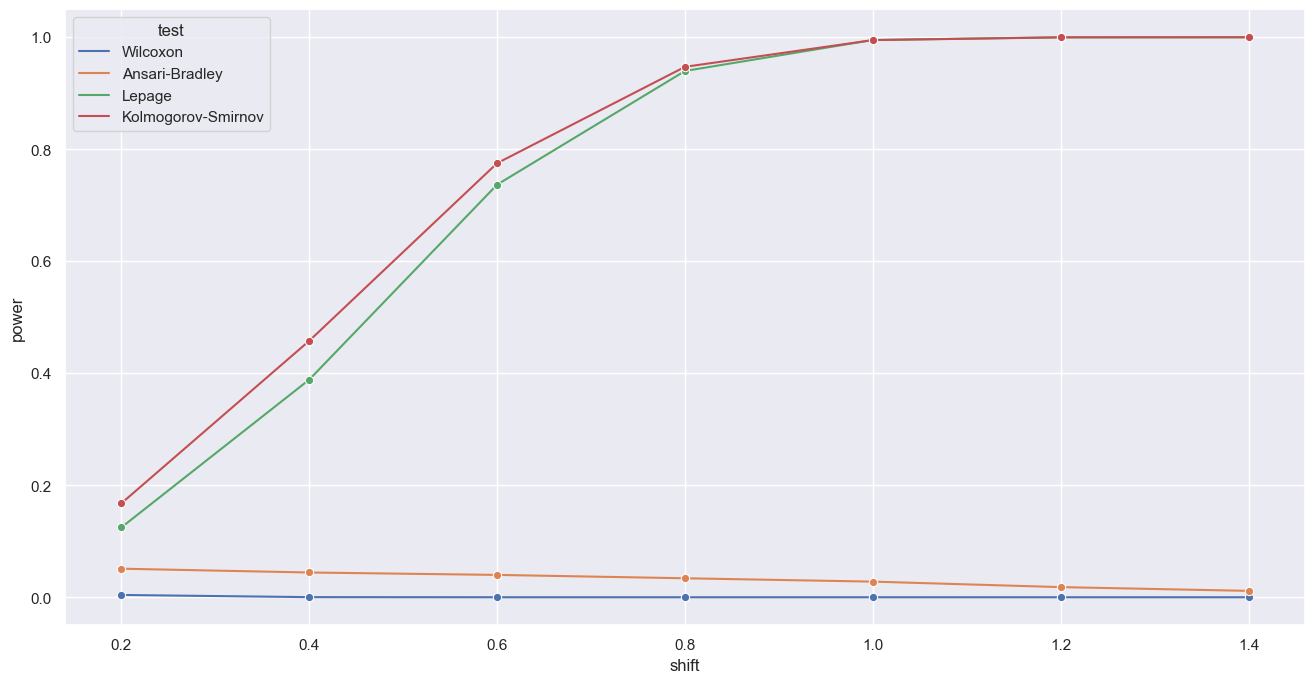

In [ ]:
print("Normal distribution with respective shift and scale parameters")
sns.lineplot(data=powers, x='shift', y='power', hue='test', marker='o')

fig = px.line(
    powers.astype({
        "shift": np.float64, "scale": np.float64, "power": np.float64, "test": str
    }), 
    x='scale', 
    y='power', 
    color='test', 
)
fig.show()

## b)

In [ ]:
t_stat, powers = make_experiment(
    func=logistic.rvs,
    params=[
        ([0, 1], [0.2, 1.0]), ([0, 1], [0.4, 1.0]), ([0, 1], [0.6, 1.0]),
        ([0, 1], [0.8, 1.0]), ([0, 1], [1.0, 1.0]), ([0, 1], [1.2, 1.0]),
        ([0, 1], [1.4, 1.0])
    ],
    n=50,
    m=50
    )

In [ ]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0.2,0.7,0.983805,1.259904,0.7
1,1.0,0.4,0.9,-0.027713,0.249600,0.9
2,1.0,0.6,1.3,-1.385641,5.656368,1.3
3,1.0,0.8,1.7,-0.595825,3.331056,1.7
4,1.0,1.0,1.3,1.635056,5.868480,1.3
5,1.0,1.2,2.3,0.180133,18.602880,2.3
6,1.0,1.4,1.2,0.956092,2.628720,1.2


Logistic distribution with respective shift and scale parameters


<AxesSubplot: xlabel='shift', ylabel='power'>

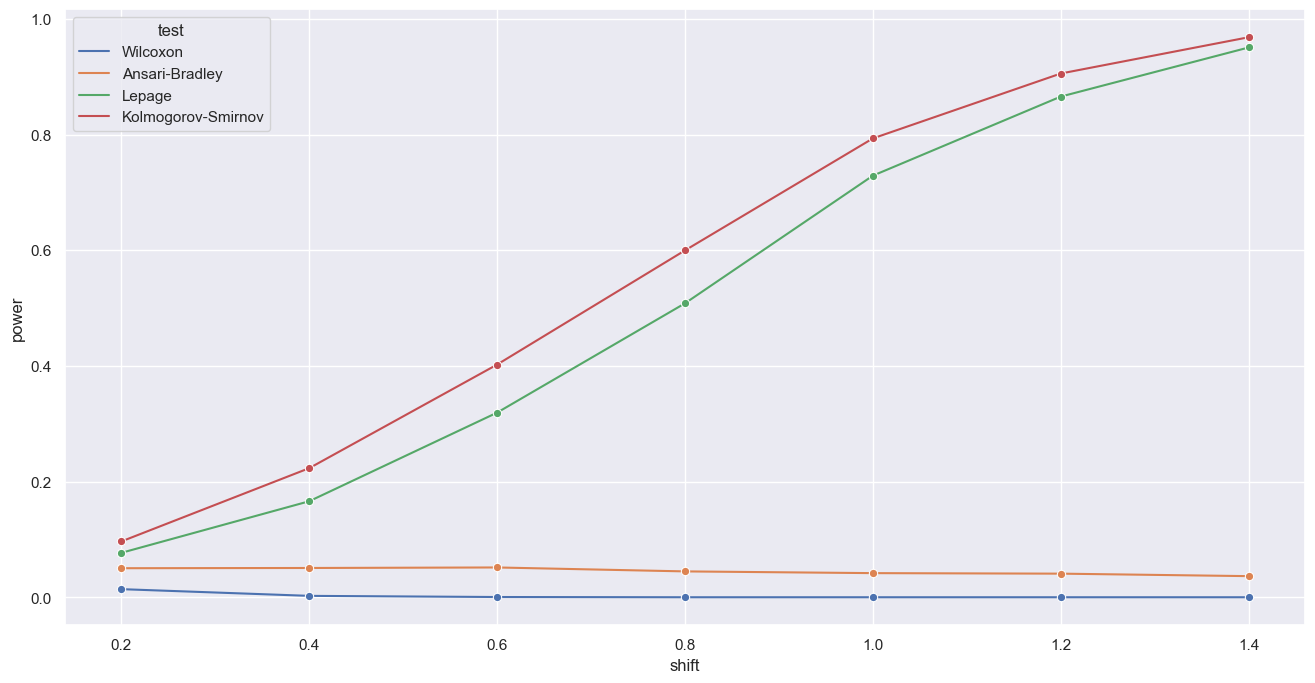

In [ ]:
print("Logistic distribution with respective shift and scale parameters")
sns.lineplot(data=powers, x='shift', y='power', hue='test', marker='o')

## c)

In [ ]:
t_stat, powers = make_experiment(
    func=cauchy.rvs,
    params=[
        ([0, 1], [0.0, 1.0]), ([0, 1], [0.5, 1.0]), ([0, 1], [1.0, 1.0]),
        ([0, 1], [1.5, 1.0]), ([0, 1], [2.0, 1.0]), ([0, 1], [2.5, 1.0]),
        ([0, 1], [3.0, 1.0])
    ],
    n=50,
    m=50
    )

In [ ]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0.0,1.9,-0.665108,8.084016,1.9
1,1.0,0.5,1.3,1.025374,5.371392,1.3
2,1.0,1.0,2.0,0.457261,6.603888,2.0
3,1.0,1.5,2.3,1.427210,19.259376,2.3
4,1.0,2.0,2.5,1.468779,13.823664,2.5
5,1.0,2.5,3.6,-1.122369,30.313344,3.6
6,1.0,3.0,3.5,0.498831,33.077424,3.5


Cauchy distribution with respective shift and scale parameters


<AxesSubplot: xlabel='shift', ylabel='power'>

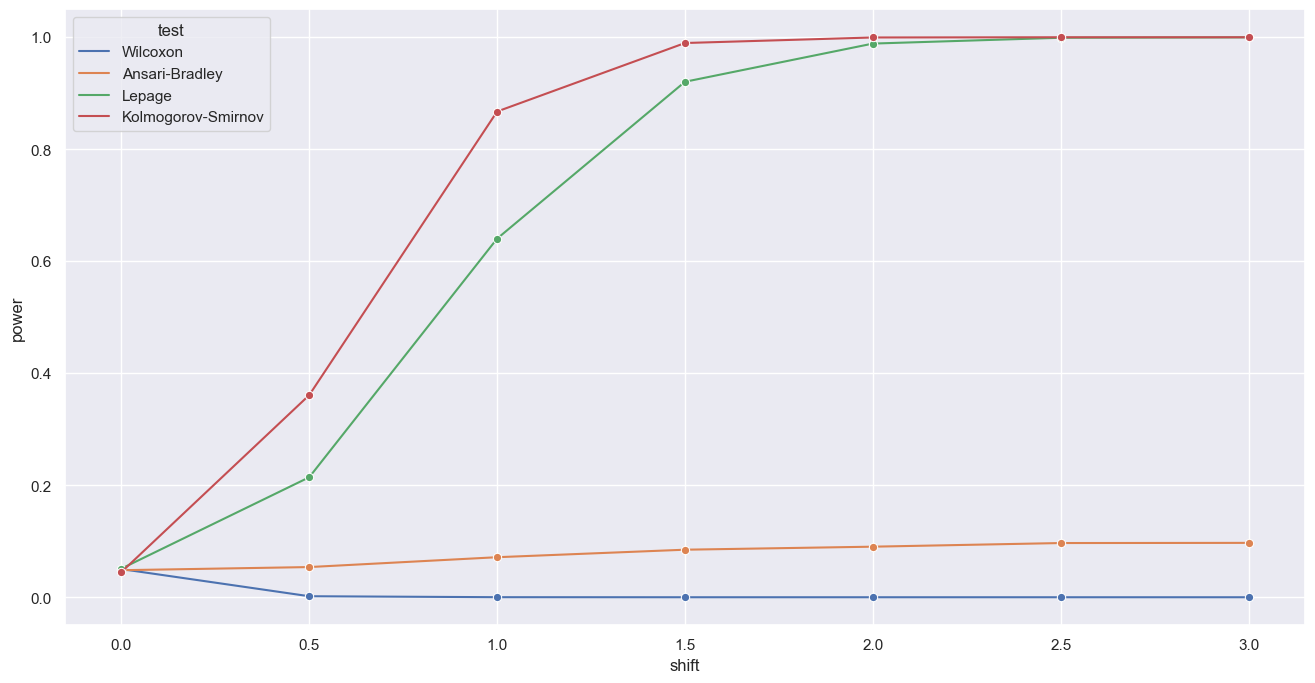

In [ ]:
print("Cauchy distribution with respective shift and scale parameters")
sns.lineplot(data=powers, x='shift', y='power', hue='test', marker='o')

## a)

In [ ]:
t_stat, powers = make_experiment(
    func=norm.rvs,
    params=[
        ([0, 1], [0, 1.0]), ([0, 1], [0, 1.5]), ([0, 1], [0, 2.0]),
        ([0, 1], [0, 2.5]), ([0, 1], [0, 3.0]), ([0, 1], [0, 3.5]),
        ([0, 1], [0, 4.0])
    ],
    n=50,
    m=50
    )

In [ ]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0,0.5,-0.193990,0.157632,0.5
1,1.5,0,0.8,2.147743,4.615152,0.8
2,2.0,0,1.5,4.711178,22.292400,1.5
3,2.5,0,1.3,3.658091,13.389744,1.3
4,3.0,0,2.0,5.958255,38.622000,2.0
5,3.5,0,1.6,6.152244,37.905600,1.6
6,4.0,0,1.9,4.822029,24.859440,1.9


Normal distribution with respective shift and scale parameters


<AxesSubplot: xlabel='scale', ylabel='power'>

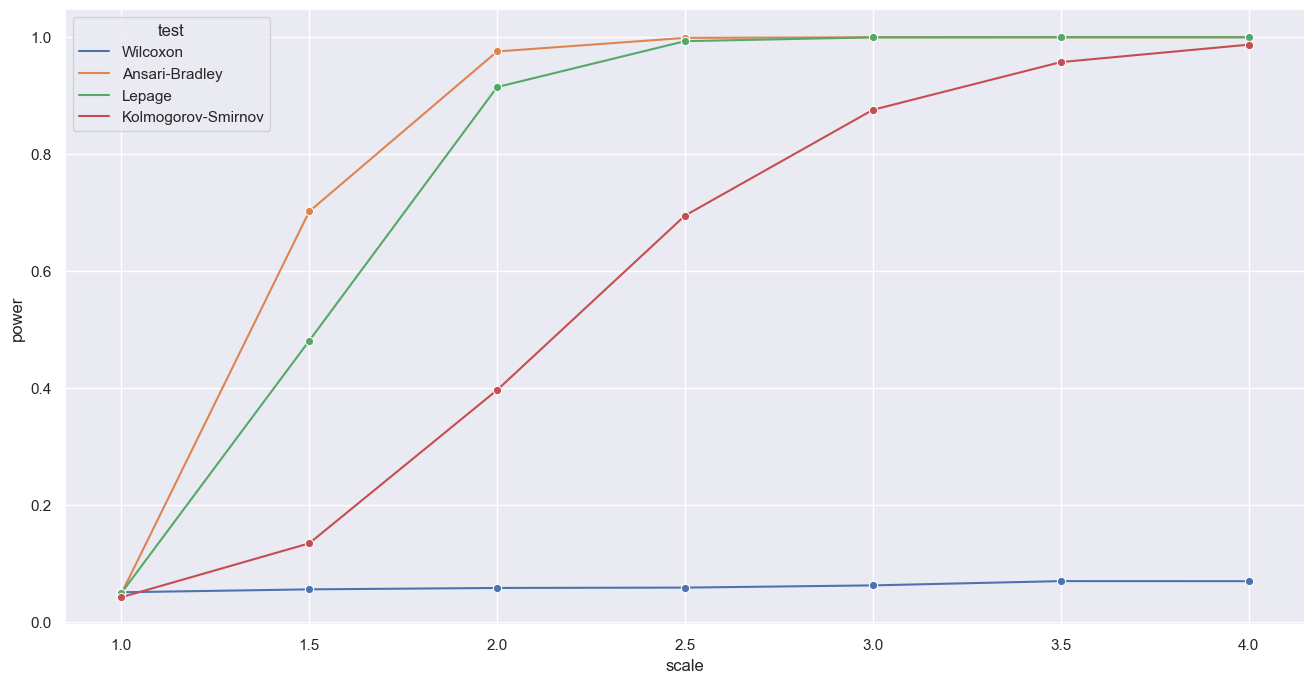

In [ ]:
print("Normal distribution with respective shift and scale parameters")
sns.lineplot(data=powers, x='scale', y='power', hue='test', marker='o')

## b)

In [ ]:
t_stat, powers = make_experiment(
    func=logistic.rvs,
    params=[
        ([0, 1], [0, 1.0]), ([0, 1], [0, 1.5]), ([0, 1], [0, 2.0]),
        ([0, 1], [0, 2.5]), ([0, 1], [0, 3.0]), ([0, 1], [0, 3.5]),
        ([0, 1], [0, 4.0])
    ],
    n=50,
    m=50
    )

In [ ]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0,0.8,1.080800,1.882560,0.8
1,1.5,0,0.8,2.036892,5.439936,0.8
2,2.0,0,1.0,2.701999,7.503600,1.0
3,2.5,0,1.4,3.865937,16.808304,1.4
4,3.0,0,1.4,4.849742,23.520048,1.4
5,3.5,0,2.0,5.362429,33.133440,2.0
6,4.0,0,1.7,4.863599,25.025520,1.7


Logistic distribution with respective shift and scale parameters


<AxesSubplot: xlabel='scale', ylabel='power'>

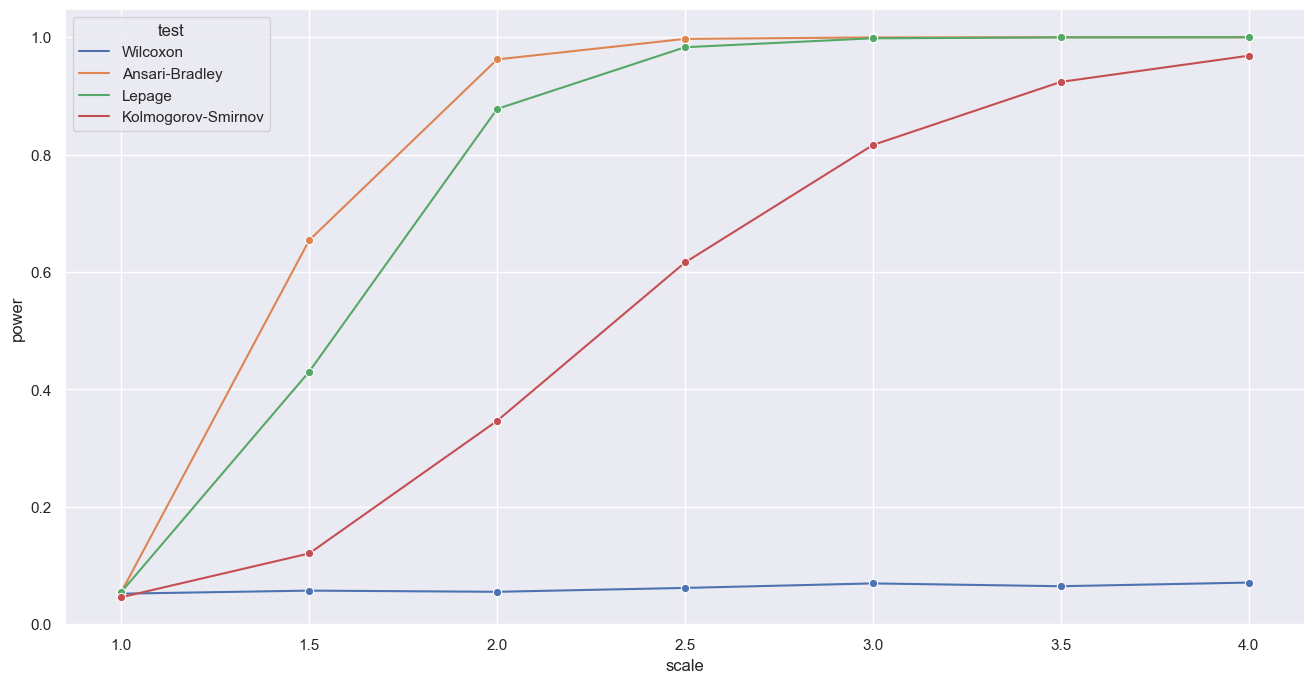

In [ ]:
print("Logistic distribution with respective shift and scale parameters")
sns.lineplot(data=powers, x='scale', y='power', hue='test', marker='o')

## c)

In [ ]:
t_stat, powers = make_experiment(
    func=cauchy.rvs,
    params=[
        ([0, 1], [0, 1.0]), ([0, 1], [0, 2.0]), ([0, 1], [0, 3.0]),
        ([0, 1], [0, 4.0]), ([0, 1], [0, 5.0]), ([0, 1], [0, 6.0]),
        ([0, 1], [0, 7.0])
    ],
    n=50,
    m=50
    )

In [ ]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0,0.8,0.318697,0.440256,0.8
1,2.0,0,1.3,2.937558,9.984000,1.3
2,3.0,0,1.1,3.505671,12.374400,1.1
3,4.0,0,1.7,4.461763,21.167040,1.7
4,5.0,0,1.7,5.819691,34.963248,1.7
5,6.0,0,1.7,4.531045,21.639360,1.7
6,7.0,0,2.0,5.902829,36.087600,2.0


Cauchy distribution with respective shift and scale parameters


<AxesSubplot: xlabel='scale', ylabel='power'>

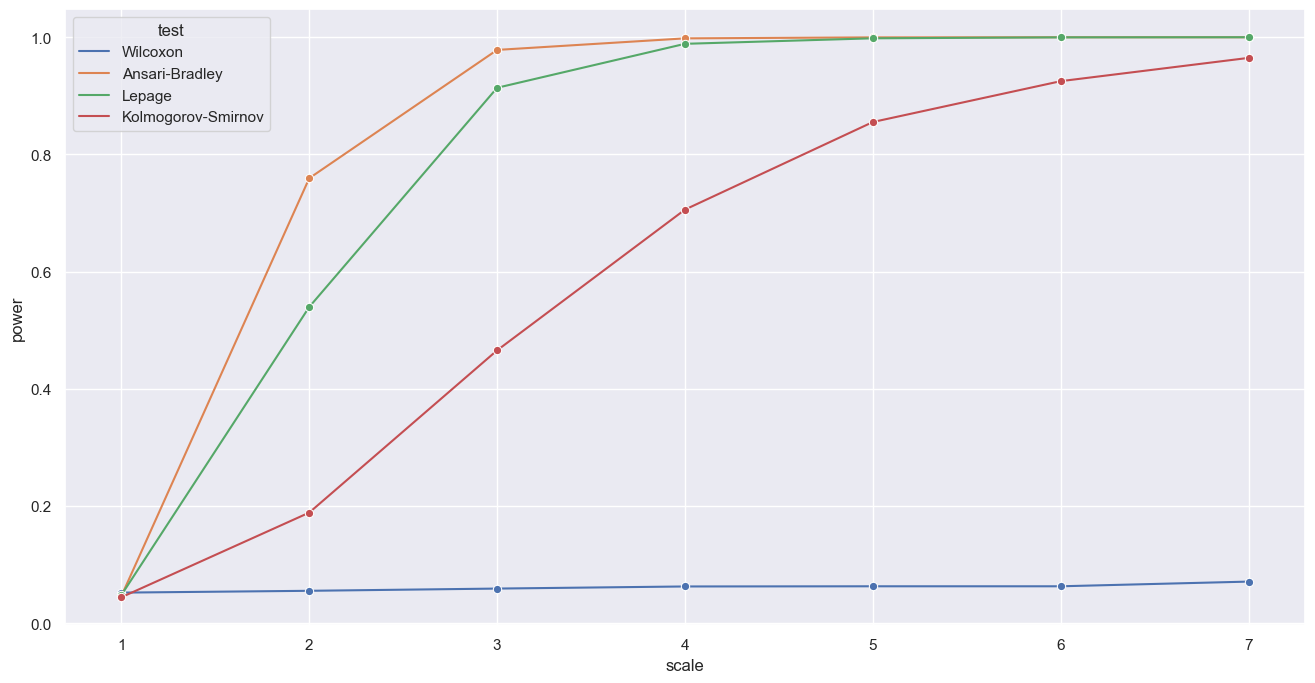

In [ ]:
print("Cauchy distribution with respective shift and scale parameters")
sns.lineplot(data=powers, x='scale', y='power', hue='test', marker='o')

## a)

In [ ]:
t_stat, powers = make_experiment(
    func=norm.rvs,
    params=[
        ([0, 1], [0.2, 1.0]), ([0, 1], [0.4, 1.5]), ([0, 1], [0.6, 2.0]),
        ([0, 1], [0.8, 2.5]), ([0, 1], [1.0, 3.0]), ([0, 1], [1.2, 3.5]),
        ([0, 1], [1.4, 4.0])
    ],
    n=50,
    m=50
    )

In [ ]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0.2,0.9,0.415692,1.355952,0.9
1,1.5,0.4,1.0,1.344071,2.532720,1.0
2,2.0,0.6,1.4,3.713517,14.913840,1.4
3,2.5,0.8,1.9,5.126870,29.119152,1.9
4,3.0,1.0,2.1,3.907507,21.454896,2.1
5,3.5,1.2,1.6,5.750409,33.473472,1.6
6,4.0,1.4,1.8,5.071445,26.343360,1.8


Normal distribution with respective shift and scale parameters


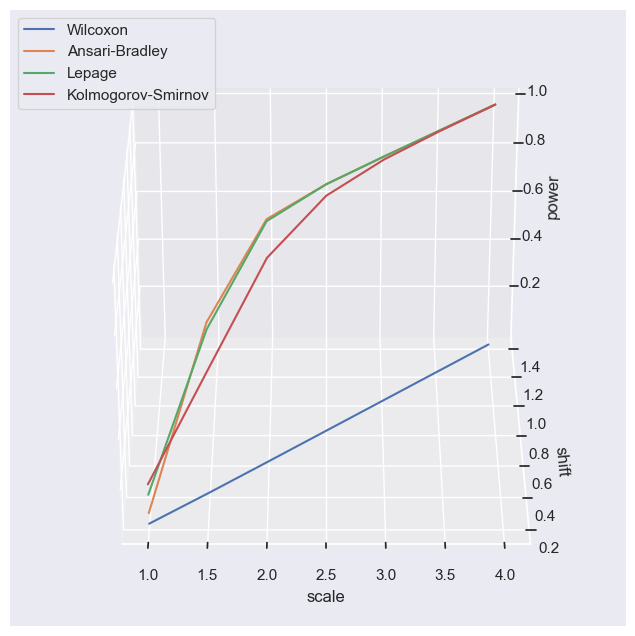

In [ ]:
print("Normal distribution with respective shift and scale parameters")
ax = plt.figure().add_subplot(projection='3d')

for test in ['Wilcoxon', 'Ansari-Bradley', 'Lepage', 'Kolmogorov-Smirnov']:
    data = powers[powers.test == test]
    x = list(data.scale)
    y = list(data['shift'])
    z = list(data.power)
    ax.plot(x, y, z, label=test)

ax.legend()
ax.set_xlabel('scale')
ax.set_ylabel('shift')
ax.set_zlabel('power')
ax.view_init(elev=30., azim=-90, roll=0)
plt.show ()

## b)

In [ ]:
t_stat, powers = make_experiment(
    func=logistic.rvs,
    params=[
        ([0, 1], [0.2, 1.0]), ([0, 1], [0.4, 1.5]), ([0, 1], [0.6, 2.0]),
        ([0, 1], [0.8, 2.5]), ([0, 1], [1.0, 3.0]), ([0, 1], [1.2, 3.5]),
        ([0, 1], [1.4, 4.0])
    ],
    n=50,
    m=50
    )

In [ ]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0.2,0.9,0.956092,1.149312,0.9
1,1.5,0.4,1.1,2.812851,8.382576,1.1
2,2.0,0.6,1.3,2.812851,8.492928,1.3
3,2.5,0.8,2.1,4.683465,25.833648,2.1
4,3.0,1.0,2.2,5.196152,30.320112,2.2
5,3.5,1.2,2.6,4.808173,32.453616,2.6
6,4.0,1.4,1.7,6.027537,36.419952,1.7


Logistic distribution with respective shift and scale parameters


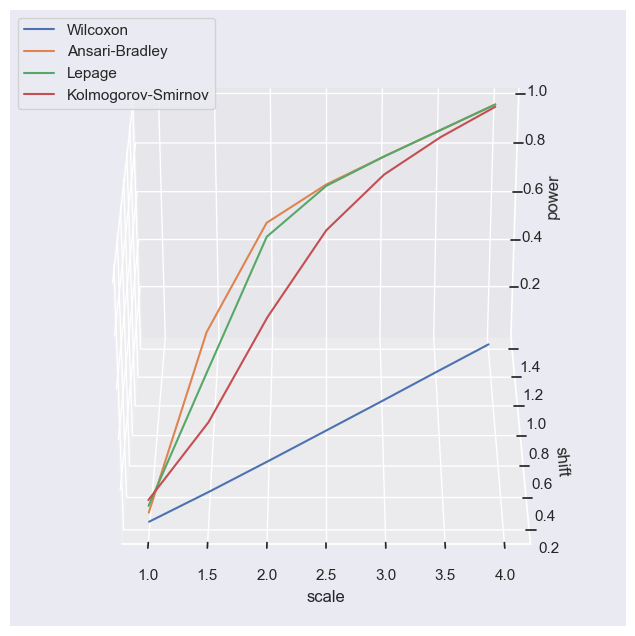

In [ ]:
print("Logistic distribution with respective shift and scale parameters")
ax = plt.figure().add_subplot(projection='3d')

for test in ['Wilcoxon', 'Ansari-Bradley', 'Lepage', 'Kolmogorov-Smirnov']:
    data = powers[powers.test == test]
    x = list(data.scale)
    y = list(data['shift'])
    z = list(data.power)
    ax.plot(x, y, z, label=test)

ax.legend()
ax.set_xlabel('scale')
ax.set_ylabel('shift')
ax.set_zlabel('power')
ax.view_init(elev=30., azim=-90, roll=0)
plt.show ()

## c)

In [ ]:
t_stat, powers = make_experiment(
    func=cauchy.rvs,
    params=[
        ([0, 1], [0, 1.0]), ([0, 1], [0.5, 2.0]), ([0, 1], [1.0, 3.0]),
        ([0, 1], [1.5, 4.0]), ([0, 1], [2.0, 5.0]), ([0, 1], [2.5, 6.0]),
        ([0, 1], [3.0, 7.0])
    ],
    n=50,
    m=50
    )

In [ ]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0.0,1.3,-0.928379,6.641520,1.3
1,2.0,0.5,0.9,2.577292,6.857904,0.9
2,3.0,1.0,1.5,3.713517,14.744496,1.5
3,4.0,1.5,1.2,3.270112,11.024304,1.2
4,5.0,2.0,1.2,3.644235,13.391040,1.2
5,6.0,2.5,2.1,6.928203,48.849072,2.1
6,7.0,3.0,2.4,5.902829,38.163504,2.4


Cauchy distribution with respective shift and scale parameters


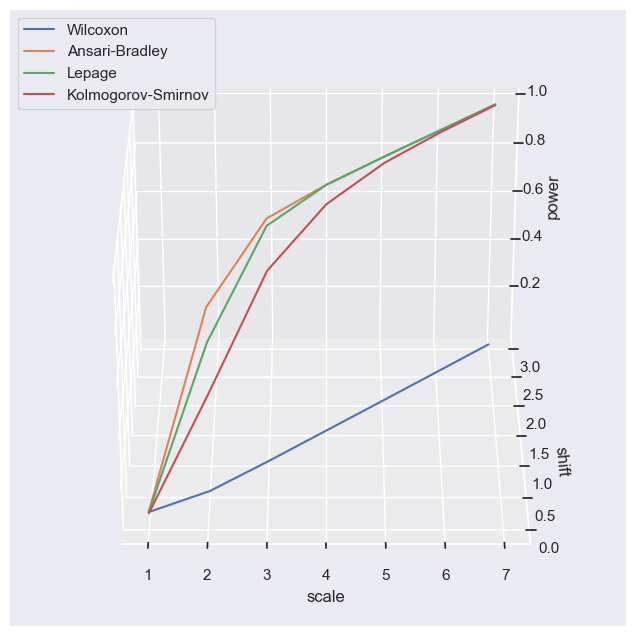

In [ ]:
print("Cauchy distribution with respective shift and scale parameters")
ax = plt.figure().add_subplot(projection='3d')

for test in ['Wilcoxon', 'Ansari-Bradley', 'Lepage', 'Kolmogorov-Smirnov']:
    data = powers[powers.test == test]
    x = list(data.scale)
    y = list(data['shift'])
    z = list(data.power)
    ax.plot(x, y, z, label=test)

ax.legend()
ax.set_xlabel('scale')
ax.set_ylabel('shift')
ax.set_zlabel('power')
ax.view_init(elev=30., azim=-90, roll=0)
plt.show ()